In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchtext import data, datasets
import torch.nn.functional as F
import torch.optim as O
import matplotlib.pyplot as plt
import scipy as sp
from model import LSTMSentiment
from argparse import ArgumentParser
from data_utils import load_sst, makedirs, get_args
from train import get_accuracy, train_model
from logit import load_sst_logistic_reg, logit_clf
from CD import CD, get_batches
import time

In [3]:
args = get_args()
torch.cuda.set_device(0)
inputs, outputs, train_iter, valid_iter, train_sst, valid_sst = load_sst(args)
args["n_embed"] = len(inputs.vocab)
args["d_out"] = len(outputs.vocab)


In [4]:
model = LSTMSentiment(args)
if os.path.isfile("results/best_snapshot.pt"):
    print("Loading best snapshot")
    model.cuda()
    model.load_state_dict(torch.load("results/best_snapshot.pt"))
else:
    model = train_model(train_iter, valid_iter, valid_sst, inputs, outputs, args)


Loading best snapshot


C:\Users\David\Anaconda3\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:116: UserWarning: 
    Found GPU0 GeForce GTX 960M which is of cuda capability 5.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [5]:
train, valid, test = load_sst_logistic_reg(args)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

vectorizer = CountVectorizer(tokenizer= lambda doc:doc, lowercase=False)

training_data = [text for text in train.text]
training_labels = [label for label in train.label]
validation_data = [text for text in valid.text]
validation_labels = [label for label in valid.label]
test_data = [text for text in test.text]
test_labels = [label for label in test.label]


bag_of_words = vectorizer.fit_transform(training_data)


clf = LogisticRegression(dual=True)
clf.fit(bag_of_words, training_labels)
predictions = clf.predict(vectorizer.transform(validation_data))

print(metrics.classification_report(validation_labels, predictions,target_names=["positive","negative"]))
print(metrics.accuracy_score(validation_labels, predictions))

             precision    recall  f1-score   support

   positive       0.82      0.80      0.81       428
   negative       0.81      0.83      0.82       444

avg / total       0.82      0.82      0.82       872

0.8188073394495413


In [7]:
validation_vectorizer = CountVectorizer(tokenizer = lambda doc:doc, lowercase=False)
validation_vectorizer.fit_transform(validation_data)
word_coef_lookup = {feature: coef for coef, feature in zip(clf.coef_[0], vectorizer.get_feature_names())}
word_validation_coef_lookup = {word:word_coef_lookup[word] for word in validation_vectorizer.vocabulary_ if word in word_coef_lookup}

In [ ]:
args["batch_size"] = 1
args["retrain"] = True
inputs, outputs, train_iter, valid_iter, train_sst, valid_sst = load_sst(args)

In [87]:
batch_nums = list(range(len(train_iter)))
data = get_batches(batch_nums, train_iter, valid_iter, dset='train') 
cd = CD(model, inputs, clf, data, vectorizer, list(train_sst.text))

getting batches...
generating dissenting subphrases


In [37]:
good_ones = [60, 15, 16]
num = 3
print("Review level CD scores")
res_review = cd.CD_phrase(cd.dissenting[num])
# print("Score: ", res_review[0][0])
# print("Review: ", res_review[0][1][:round(len(res_review[0][1])/3)])
# print(res_review[0][1][round(len(res_review[0][1])/3):round(len(res_review[0][1])* 2 /3)])
# print(res_review[0][1][round(len(res_review[0][1])* 2 /3):])
print("Word level CD scores")
res_by_word = cd.CD_word(cd.dissenting[num])


Review level CD scores
-2.5398316055963397 It is not the first time that director Sara Sugarman stoops to having characters drop their pants for laughs and not the last time she fails to provoke them .
Word level CD scores
-0.003252903332193535 It
0.00492665892694886 is
-2.6498286481262303 not
0.0010447013470228576 the
0.010232128515278934 first
-0.000788582019885952 time
0.003278804608410117 that
0.021984666088952547 director
0.0032363585051035882 Sara
0.013292096814572347 Sugarman
0.01782562792786881 stoops
0.0415224319003837 to
0.02951399523121267 having
0.018545239267046695 characters
0.09853768847023105 drop
0.043419493144877176 their
0.12168436357057612 pants
0.07241543260188105 for
0.22509284688408052 laughs
0.04446658118462589 and
-0.8730439460218311 not
0.10929900660097053 the
0.13724471499655827 last
0.2741203028998622 time
0.17568253934908248 she
-2.040897092760302 fails
0.4323055804559702 to
-0.2676455379051237 provoke
0.33136646751600707 them
0.2490989153002177 .


In [16]:
words = {}
if os.path.isfile("CD_SCORE_individual.csv"):
    df = pd.read_csv("CD_SCORE_individual.csv", index_col=0)
    words = {row["word"]:row["score"] for index, row in df.iterrows()} 
else:
    #Array of phrases
    for ind in range(len(data)):
        if ind%50 ==0:
            print("ind", ind)
        text = data[ind].text.data[:, 0]
        vect2Word = [inputs.vocab.itos[i] for i in text]
    #     print (vect2Word)
        for i in range(len(vect2Word)):
            if(vect2Word[i] not in words):
                words[vect2Word[i]] = cd.context_decomp(data[ind], i, i)
    df = pd.DataFrame(list(words.items()), columns=["word", "score"])
    df.to_csv("CD_SCORE_individual.csv")

(0.48990854641103804, 1.0078087766148135e-212)


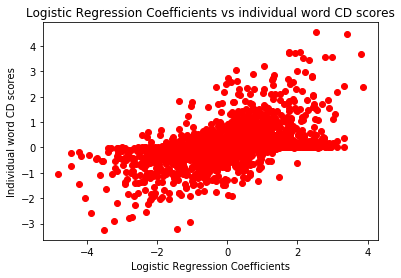

In [24]:
x=[]
y=[]

for key, val  in word_validation_coef_lookup.items():
    if key in words:
        x.append(word_validation_coef_lookup[key])
        y.append(words[key])
    
print(sp.stats.pearsonr(x,y))
# y_10 = [y * 10 for elem in y]
plt.title("Logistic Regression Coefficients vs individual word CD scores")
plt.xlabel("Logistic Regression Coefficients")
plt.ylabel("Individual word CD scores")
plt.plot(x , y, 'ro')
plt.show()

In [119]:
import nltk
from nltk.tree import Tree

ROOT = 'ROOT'

negation_terms = set(['not', 'n’t', 'lacks', 'nobody', 'nor', 'nothing', 'neither', 'never', 'none', 'nowhere', 'remotely'])
parents_set = list()

trees = []
with open(os.path.expanduser('./.data/sst/trees/train.txt')) as f:
    for line in f:
        tree = Tree.fromstring(line)
        trees.append(tree)

def getNegatingSubphrases(parent, review_id, review, parent_index, tree_height):
    nodes = [{"node":node} for node in parent]
    start_index = parent_index
  
  # Get the start and end indexes for each child based off of their parent's index. 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            end_index = len(node["node"].leaves()) + start_index
            node['start_index'] = start_index
            node['end_index'] = end_index
            start_index = end_index
      
    if len(parent.leaves()) < 10:
        if len(nodes) >= 2:
            first_child = nodes[0]['node']
            second_child = nodes[1]['node']
            first_child_first_two_words = set()
            if type(first_child) is str:
                first_child_first_two_words = set(list(first_child))
            else:
                first_child_first_two_words = set(list(first_child.leaves())[:2])
            # if the first child has some negation terms
            if first_child_first_two_words.intersection(negation_terms):
                if int(second_child.label()) in [0,1,3,4]:
                    parents_set.append({"review_id":review_id,"review":review, 
                                        "parent":parent, 
                                        "first_child": first_child, 
                                        "second_child":second_child, 
                                        "first_child_start_index":nodes[0]['start_index'],
                                        "first_child_end_index":nodes[0]['end_index'],
                                        "second_child_start_index": nodes[1]['start_index'],
                                        "second_child_end_index": nodes[1]['end_index'],
                                        "height":tree_height,
                                        "negation_subphrase": nodes[1]['node']
                                        })

  # keep on recursing 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            getNegatingSubphrases(node['node'], review_id, review, node['start_index'], tree_height + 1)

for i, tree in enumerate(trees):
    getNegatingSubphrases(tree, i, tree, 0,0)

    

In [19]:
negative_labels = set([0,1])
positive_labels = set([3,4])

dissenting_subphrase_reviews = []
def getDissentingSubphrase(parent, review_label, review_length, review, review_id,parent_index, tree_height):
    continue_recursion = True

    nodes = [{"node":node} for node in parent]
    start_index = parent_index

    # Get the start and end indexes for each child based off of their parent's index. 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            end_index = len(node["node"].leaves()) + start_index
            node['start_index'] = start_index
            node['end_index'] = end_index
            start_index = end_index
  
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            node_label = int(node['node'].label())
            node_length = len(node['node'].leaves())
            if ((review_label in negative_labels and node_label in positive_labels) or (review_label in positive_labels and node_label in negative_labels)):
                if (review_length / float(3)) < node_length and (review_length * 2.0 / float(3)) > node_length:
                    dissenting_subphrase_reviews.append({"review_id":review_id,
                                                       "review":review, 
                                                       "parent":parent,
                                                       "child_start_index":node['start_index'],
                                                       "child_end_index":node['end_index'],
                                                       "dissenting_subphrase": node['node'],
                                                       "height":tree_height})
   
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            getDissentingSubphrase(node['node'], review_label, review_length, review, review_id, node['start_index'], tree_height+1)

for i,tree in enumerate(trees):
    getDissentingSubphrase(tree, int(tree.label()), len(tree.leaves()), tree, i, 0, 0)

In [20]:
review_lookup = {}
#Array of phrases
for ind in range(len(data)):
    text = data[ind].text.data[:, 0]
    vect2Word = tuple(inputs.vocab.itos[i] for i in text)
    review_lookup[vect2Word] = data[ind]

In [121]:
negation_subphrase_cd_scores = []
negation_subphrase_labels = [] 
for review in parents_set:
    if tuple(review["review"].leaves()) in review_lookup and review['second_child_end_index'] - review['first_child_start_index'] < 5:
#     if tuple(review["review"].leaves()) in review_lookup:
        review_vector = review_lookup[tuple(review["review"].leaves())]
        a = cd.context_decomp(review_vector, review['first_child_start_index'],review['second_child_end_index'])
        b = cd.context_decomp(review_vector, review['first_child_start_index'], review['first_child_end_index'])
        c = cd.context_decomp(review_vector, review['second_child_start_index'], review['second_child_end_index']) 
        
        score = a-(b+c)
        negation_subphrase_cd_score = score

        subphrase_label = review['negation_subphrase'].label()

        negation_subphrase_cd_scores.append(negation_subphrase_cd_score)
        negation_subphrase_labels.append(subphrase_label)  

118


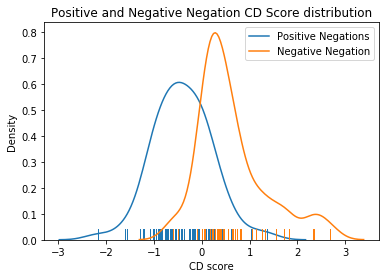

In [125]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns


negative_labels = set([0,1])
positive_labels = set([3,4])

results = zip(negation_subphrase_cd_scores, negation_subphrase_labels)
positive_subphrase_cd_scores = [score for score, label in results if int(label) in [3,4]]
results = zip(negation_subphrase_cd_scores, negation_subphrase_labels)
negative_subphrase_cd_scores = [score for score, label in results if int(label) in [0,1]]

x = np.asarray(positive_subphrase_cd_scores)
x2 = np.asarray(negative_subphrase_cd_scores)
sns.distplot(x,hist=False, rug=True, label="Positive Negations")
sns.distplot(x2,hist=False, rug=True, label="Negative Negation")
plt.title('Positive and Negative Negation CD Score distribution')
plt.xlabel('CD score')
plt.ylabel('Density')
print(len(negation_subphrase_cd_scores))
plt.legend()
plt.show()

In [21]:
dissenting_subphrase_cd_scores = []
dissenting_subphrase_labels = [] 
for review in dissenting_subphrase_reviews:
    review_vector = review_lookup[tuple(review['review'].leaves())]
    dissenting_subphrase_cd_score = cd.context_decomp(review_vector, review['child_start_index'],review['child_end_index'])
    subphrase_label = review['dissenting_subphrase'].label()
    
    dissenting_subphrase_cd_scores.append(dissenting_subphrase_cd_score)
    dissenting_subphrase_labels.append(subphrase_label)


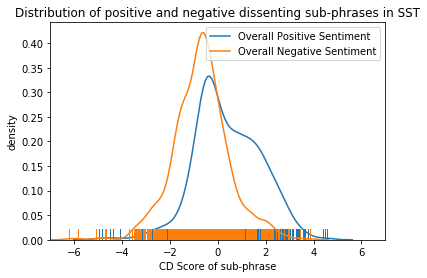

In [26]:
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

results = zip(dissenting_subphrase_cd_scores, dissenting_subphrase_labels)
positive_subphrase_cd_scores = [score for score, label in results if int(label) in [3,4]]
results = zip(dissenting_subphrase_cd_scores, dissenting_subphrase_labels)
negative_subphrase_cd_scores = [score for score, label in results if int(label) in [0,1]]

x = np.asarray(positive_subphrase_cd_scores)
x2 = np.asarray(negative_subphrase_cd_scores)
plt.xlim(-7, 7)
sns.distplot(x,hist=False, rug=True, label="Overall Positive Sentiment")
sns.distplot(x2,hist=False, rug=True, label="Overall Negative Sentiment")
plt.title("Distribution of positive and negative dissenting sub-phrases in SST")
plt.xlabel("CD Score of sub-phrase")
plt.ylabel("density")
plt.legend()
plt.show()

In [55]:
review = dissenting_subphrase_reviews[2]
data_batch = review_lookup[tuple(review["review"].leaves())]
cd.CD_diss_subphrases(data_batch, review['child_start_index'],review['child_end_index'])

[('What', 0.0024816612070703396),
 ("`` Empire '' lacks in depth it", -2.6402819544530844),
 ('makes up for with its heart .', 3.166919724192093)]

In [134]:
negating_review = parents_set[1]
negating_batch = review_lookup[tuple(negating_review["review"].leaves())]
overall = cd.CD_negating_subphrases(negating_batch, 
                          negating_review['first_child_start_index'], 
                          negating_review['first_child_end_index'], 
                          negating_review['second_child_start_index'],
                          negating_review['second_child_end_index']
                         )
print("Complete review: ", overall["overall"])
print("Overall negation: ", overall["negation_phrase"])
print("Negation term: ", overall["negation_term"])
print("Negated phrase: ", overall["negated_phrase"])

Complete review:  ("It 's been done before but never so vividly or with so much passion .", 3.8303639128441405)
Overall negation:  ('never so vividly or', 0.5223376421334937)
Negation term:  ('never', -0.735539570101045)
Negated phrase:  ('so vividly or', 1.3691544020731978)
